In [3]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import torch
import torch.nn as nn
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
import string
import math
import random
import warnings
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, accuracy_score
from glove import Corpus, Glove

warnings.filterwarnings("ignore", message="No positive samples in y_true, true positive value should be meaningless")
warnings.filterwarnings("ignore", message="No negative samples in y_true, false positive value should be meaningless")



# Reading the data

In [4]:
vocab_path='imdb.vocab'

def make_vocab(path):
    # Reading imdb vocab file
    with open(path,encoding="utf8") as file:
        words_list=file.readlines()
    
    # Splitting /n and "" from the words
    words_list=[s.split('\n')[0].split('""')[0] for s in words_list]
    # Generating a list of lists containing the vocab word
    words_list=[[word] for word in words_list]
    return words_list

# A list to hold the imdb vocab
words_list=make_vocab(vocab_path)

In [5]:

# Function to read the  imdb files
def read_files(path):
    """
    Run this script from the root directory
    """
    for file in glob.glob(f"{path}\*.txt"):
        yield file
        
# Function to clean a review query (lower case, special characters)        
def clean_query(query):
    for punc in string.punctuation:
        if punc == "'":
            query=query.replace(punc,'')
        else:
            query=query.replace(punc,' ')
    return query.replace('br',' ')

# Function to load reviews
def load_reviews(path):
    reviews = {}
    for file_name in read_files(path):
        split=file_name.split('_')
        if len(split)==2:
            review_ind=int(split[0].split('\\')[-1])
            if review_ind not in reviews:
                with open(file_name, encoding='UTF-8') as file:
                    reviews[review_ind]=([clean_query(file.read())],int(split[1].split('.')[0]))
    return reviews

    
# Function to initiate loading of positive reviews
def load_positive_reviews():
    path = "train/pos"
    return load_reviews(path)

# Function to initiate loading of negative reviews
def load_negative_reviews():
    path = "train/neg"
    return load_reviews(path)
    
# Function that creates a word counter in all of the reviews and deletes word with less than 5 appearances
def create_word_counter(reviews):
    reviews_list =reviews
    word_counter = {}
    for review in reviews_list.values():
        review_text = review[0][0]
        for word in review_text.split():
            if word.lower() in word_counter:
                word_counter[word.lower()] +=1
            else:
                word_counter[word.lower()] =1
    # Remove words with less than 5 appearances
    words_to_remove = set()
    clean_word_counter = {}
    for word, count in word_counter.items():
        if count < 5: 
            words_to_remove.add(word)
        else:
            clean_word_counter[word] = count
            
    for review in reviews_list.keys(): 
        review_text = reviews_list[review][0][0]
        text_without_uncommon_words = []
        for word in review_text.split():
            if word not in words_to_remove:
                text_without_uncommon_words.append(word)
        reviews_list[review]=([" ".join(text_without_uncommon_words)],reviews_list[review][1])

        
    return clean_word_counter, reviews_list

# Function to transform the reviews to lower case
def lower(query):
    return " ".join(list(map(lambda x:x.lower(),query.split())))

# Function to concatenate all reviews into one list
def concatsentences(lst,query):
    lst.append(lower(query[0]).split())
    return


wc, clean_reviews = create_word_counter(load_positive_reviews())

print(clean_reviews[0])
print(wc)                    

(['Bromwell High is a cartoon comedy It ran at the same time as some other programs about school life such as Teachers My 35 years in the teaching profession lead me to believe that Bromwell Highs satire is much closer to reality than is Teachers The to survive financially the insightful students who can see right through their pathetic teachers pomp the of the whole situation all remind me of the schools I knew and their students When I saw the episode in which a student repeatedly tried to burn down the school I immediately recalled at High A classic line INSPECTOR Im here to sack one of your teachers STUDENT Welcome to Bromwell High I expect that many adults of my age think that Bromwell High is far fetched What a pity that it isnt'], 9)
{'bromwell': 8, 'high': 1097, 'is': 57254, 'a': 83954, 'cartoon': 247, 'comedy': 1737, 'it': 39397, 'ran': 121, 'at': 11243, 'the': 173315, 'same': 1972, 'time': 6509, 'as': 26313, 'some': 7442, 'other': 5369, 'programs': 41, 'about': 8313, 'school'

In [6]:
# Loading all reviews into positive and negative lists

sentences=[]
pos_reviews=create_word_counter(load_positive_reviews())[1]
neg_reviews=create_word_counter(load_negative_reviews())[1]

for query in pos_reviews.keys():
    concatsentences(sentences,pos_reviews[query][0])

for query in neg_reviews.keys():
    concatsentences(sentences,neg_reviews[query][0])



# Training and creating Word2Vec Embeddings

### We are training a new W2V Model using the reviews as sentences (and not a pre-trained model)

In [7]:
# Function to tokenize words in reviews using word2vec
def tokenize(query,model):
    return torch.LongTensor([model.wv.get_index(token) for token in query.split()])

# Function to create word2vec embedding
def w2vembedding(query,model):
    query=lower(clean_query(query))
    weights = torch.FloatTensor(model.wv.vectors)
    embedding = nn.Embedding.from_pretrained(weights)

    indx=tokenize(query,model)
    return embedding(indx)




# Training 3 new w2v embedding based on imdb vocab to compare their performence afterwards

modelw2v=Word2Vec(sentences=sentences
                  ,vector_size=150
                  ,min_count=1, window=3)

# modelw2vexpended1=Word2Vec(sentences=sentences
#                   ,vector_size=100
#                   ,min_count=1, window=10)

modelw2vexpended2=Word2Vec(sentences=sentences
                  ,vector_size=200
                  ,min_count=1, window=20)

In [8]:
# Word Similarities - (sanity check)

modelw2v.wv.most_similar("batman")

[('superman', 0.7041171789169312),
 ('dracula', 0.6403812170028687),
 ('trilogy', 0.6221661567687988),
 ('comics', 0.6114967465400696),
 ('bourne', 0.6084699034690857),
 ('godzilla', 0.6049008965492249),
 ('godfather', 0.5879895091056824),
 ('gadget', 0.5847970843315125),
 ('1978', 0.5793613791465759),
 ('1971', 0.5787938237190247)]

In [7]:
# modelw2vexpended1.wv.most_similar("batman")

[('superman', 0.7337108850479126),
 ('gadget', 0.6515796184539795),
 ('iii', 0.6388566493988037),
 ('joker', 0.6376195549964905),
 ('galactica', 0.6239655017852783),
 ('trilogy', 0.6180299520492554),
 ('godzilla', 0.6144089698791504),
 ('jerry', 0.6095067858695984),
 ('comics', 0.6078493595123291),
 ('phantasm', 0.606647789478302)]

In [9]:
modelw2vexpended2.wv.most_similar("batman")

[('joker', 0.770302414894104),
 ('superman', 0.7413424253463745),
 ('gadget', 0.7004817724227905),
 ('btas', 0.671449601650238),
 ('cartoon', 0.649263858795166),
 ('phantasm', 0.6472722291946411),
 ('comics', 0.6468921303749084),
 ('gotham', 0.6355350017547607),
 ('iii', 0.6341395378112793),
 ('lotr', 0.6264868378639221)]

# Training and creating Glove Embeddings

### We are training a new Glove Model using the reviews as sentences (and not a pre-trained model)

In [10]:
# Function to train the glove model using the dictionary created from the reviews
def glovetrain(vocab,window,vec_size):
    
    # instantiate the corpus
    glcorpus = Corpus()
    
    # this will create the word co occurence matrix 
    # window - the distance between two words algo should consider to find some relationship between them
    glcorpus.fit(vocab, window=window)

    # instantiate the model
    # no_components - output vector size
    glovemod = Glove(no_components=vec_size, learning_rate=0.05)


    # and fit over the corpus matrix
    glovemod.fit(glcorpus.matrix, epochs=10, no_threads=4)

    # finally we add the vocabulary to the model
    glovemod.add_dictionary(glcorpus.dictionary)
    
    return glovemod

# Training 3 new glove embedding based on imdb vocab to compare their performence afterwards

glove_model=glovetrain(sentences,20,150)

# glove_model_expended1=glovetrain(sentences,10,100)

glove_model_expended2=glovetrain(sentences,25,200)

In [11]:
# Word Similarities - (sanity check)

glove_model.most_similar("batman")

[('series', 0.8569044795087859),
 ('cartoon', 0.8384856807488115),
 ('disney', 0.8330351683953942),
 ('tv', 0.8289053489570903)]

In [50]:
# glove_model_expended1.most_similar("batman")

[('silent', 0.8645706601555658),
 ('series', 0.8620348796197477),
 ('cartoon', 0.8569323535080106),
 ('version', 0.8538018798571195)]

In [12]:
glove_model_expended2.most_similar("batman")

[('superman', 0.838781276113971),
 ('series', 0.8205870666189249),
 ('tv', 0.8084640844622542),
 ('cartoon', 0.8037135156011439)]

In [13]:
## Functions for glove embeddings

def tokenize_glove(query,model):
    return torch.tensor([glove_model.dictionary[token] for token in query.split()])

def glove_embedding(query,model):
    query=lower(clean_query(query))
    weights = torch.FloatTensor(model.word_vectors)
    embedding = nn.Embedding.from_pretrained(weights)

    indx=tokenize_glove(query,model)
    return embedding(indx)

# Arranging the data

In [14]:
## Shuffling concatenated data to keep the order of the tagging
def shuffledata(x_lst,y_lst):
    z=list(zip(x_lst,y_lst))
    random.shuffle(z)
    x,y=zip(*z)
    return x,y

# The class helps us to merge the input and labels into a single class which the dataloader operates on
class DLcorrection:
    def __init__(self, reviews, targets,embedding,model):
        self.reviews=[embedding(review[0],model) for review in reviews]
        self.targets=targets
        
    def __getitem__(self, idx):
        # Get the input features and labels from the current image index
        review = self.reviews[idx]
        targets = self.targets[idx]
        return review,targets     

    def __len__(self):
        return len(self.targets)

# Loading positive and negative reviews
x_pos=[pos_reviews[i][0] for i in range(len(pos_reviews.keys()))]
y_pos=[1 for i in range(len(pos_reviews.keys()))]
x_neg=[neg_reviews[i][0] for i in range(len(neg_reviews.keys()))]
y_neg=[0 for i in range(len(neg_reviews.keys()))]


## Stratifying the train and test sets
x_pos_train, x_pos_test, y_pos_train, y_pos_test = train_test_split(x_pos, y_pos, test_size=0.98, random_state=42)
x_neg_train, x_neg_test, y_neg_train, y_neg_test = train_test_split(x_neg, y_neg, test_size=0.98, random_state=42)

x_combined_train=x_pos_train+x_neg_train
x_combined_test=x_pos_test[:200]+x_neg_test[:200]
y_combined_train=y_pos_train+y_neg_train
y_combined_test=y_pos_test[:200]+y_neg_test[:200]

x_final_train,y_final_train=shuffledata(x_combined_train,y_combined_train)
x_final_test,y_final_test=shuffledata(x_combined_test,y_combined_test)

# Pushing the train and test input and labels to a class which helps us to get the right input,label for each image- W2V
train_set_united=DLcorrection(list(x_final_train),list(y_final_train),w2vembedding,modelw2v)
test_set_united=DLcorrection(list(x_final_test),list(y_final_test),w2vembedding,modelw2v)

# Doing the same for glove
train_set_united_glove=DLcorrection(list(x_final_train),list(y_final_train),glove_embedding,glove_model)
test_set_united_glove=DLcorrection(list(x_final_test),list(y_final_test),glove_embedding,glove_model)

# Repeating for w2v and glove expended models
# train_set_united_expeneded1=DLcorrection(list(x_final_train),list(y_final_train),w2vembedding,modelw2vexpended1)
# test_set_united_expeneded1=DLcorrection(list(x_final_test),list(y_final_test),w2vembedding,modelw2vexpended1)

train_set_united_expended2=DLcorrection(list(x_final_train),list(y_final_train),w2vembedding,modelw2vexpended2)
test_set_united_expeneded2=DLcorrection(list(x_final_test),list(y_final_test),w2vembedding,modelw2vexpended2)

# train_set_united_glove_expended1=DLcorrection(list(x_final_train),list(y_final_train),glove_embedding,glove_model_expended1)
# test_set_united_glove_expended1=DLcorrection(list(x_final_test),list(y_final_test),glove_embedding,glove_model_expended1)

train_set_united_glove_expended2=DLcorrection(list(x_final_train),list(y_final_train),glove_embedding,glove_model_expended2)
test_set_united_glove_expeneded2=DLcorrection(list(x_final_test),list(y_final_test),glove_embedding,glove_model_expended2)


# LSTM net class

In [18]:
class lstmnet(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        #i_t
        self.W_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        
        #f_t
        self.W_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        
        #c_t
        self.W_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        
        #o_t
        self.W_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        
        # Sigmoid layer
        self.sigmoid=nn.Sigmoid()
        # FC layer
        self.fc1=nn.Linear(hidden_sz,1)
        
        # Initializing parameters weights
        self.init_weights()
        
        
    def init_weights(self):
        # Assigning random weights from a stdv (generated from 1 / number of hidden neurons) distribution
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)
    
    def forward(self,
                x,
                init_states=None):
        
        """
        assumes x.shape represents (batch_size, sequence_size, input_size)
        """
        batchsize, seq_sz, _ = x.size()
        hidden_seq = []
        # If no initial states were given, initialize them with zeros
        if init_states is None:
            h_t, c_t = (
                torch.zeros(batchsize, self.hidden_size),
                torch.zeros(batchsize, self.hidden_size),
            )
        else:
            h_t, c_t = init_states
        
        # For each word, compute the next state
        for t in range(seq_sz):
            x_t = x[:, t, :]
            
            # @ Stands for matrix multiplication(inner product)
            
            i_t = torch.sigmoid(x_t @ self.W_i + h_t @ self.U_i)
            f_t = torch.sigmoid(x_t @ self.W_f + h_t @ self.U_f)
            g_t = torch.tanh(x_t @ self.W_c + h_t @ self.U_c)
            o_t = torch.sigmoid(x_t @ self.W_o + h_t @ self.U_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            
            
            hidden_seq.append(h_t.unsqueeze(0))
    
        #reshape hidden_seq p/ retornar
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        

        self.vec=h_t
        
        out=self.fc1(h_t)[0]
        return self.sigmoid(out)


# LSTM W2V Train

In [19]:
# Initiate the model with w2v
model=lstmnet(150,150)

# Specify loss function - Binary Cross Entropy
criterion = nn.BCELoss()
# Specify optimizer - Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer2 = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer3 = torch.optim.Adam(model.parameters(), lr=0.002)



# Batch size will be 1 review at a time
batch_size=1
batch_size_test=1

# Loading the train and test set to a generator to save space
train_loader = torch.utils.data.DataLoader(train_set_united, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set_united, batch_size=batch_size_test)

# Number of epochs to train the model
n_epochs = 5

# Lists to store metrics
losses_train_list = []
accuracy_train_list = []

losses_test_list = []
accuracy_test_list = []

for epoch in tqdm(range(1, n_epochs+1)):
    # Monitor training loss
    train_loss = 0.0
    accuracy=0.0
    accuracy_test=0.0

    ###################
    # Train the model #
    ###################
    model.train()
    for review,rating in train_loader:
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Create embedding
        embedding=review
        # Forward pass: compute predicted outputs by passing inputs to the model, assuring the values are of type float
        outputs = model(embedding)
        # Calculate the loss
        loss = criterion(outputs, rating.float())
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update running training loss
        train_loss += loss.item()
        # Update running training accuracy
        outputs_acc=outputs.detach().numpy()
        accuracy+=accuracy_score(rating, np.round(outputs_acc))
    
    # Add train loss and accuracy to lists
    losses_train_list.append(train_loss/len(train_loader))
    accuracy_train_list.append(accuracy/len(train_loader))
    

    


    # Canceling the gradient optimizer while running on the validation data set (to save memory)
    with torch.no_grad():
        for review,rating in test_loader:
                # Create embedding
                embedding=review
                # Forward pass: compute predicted outputs by passing inputs to the model, assuring the values are of type float
                outputs = model(embedding)
                outputs_acc_test=outputs.detach().numpy()
                accuracy_test+=accuracy_score(rating, np.round(outputs_acc_test))


#     accuracy_test_list.append(accuracy/len(train_loader))
    accuracy_test_list.append(accuracy_test/len(test_loader))
    

    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    
    print('Epoch: {} \tTraining Accuracy: {:.6f}'.format(
        epoch, 
        accuracy/len(train_loader)
        ))
    
    print('Epoch: {} \tValidation Accuracy: {:.6f}'.format(
        epoch, 
        accuracy_test/len(test_loader)
        ))
    

 20%|████████████████▌                                                                  | 1/5 [02:07<08:30, 127.50s/it]

Epoch: 1 	Training Loss: 0.744837
Epoch: 1 	Training Accuracy: 0.506000
Epoch: 1 	Validation Accuracy: 0.515000


 40%|█████████████████████████████████▏                                                 | 2/5 [04:04<06:03, 121.30s/it]

Epoch: 2 	Training Loss: 0.685406
Epoch: 2 	Training Accuracy: 0.578000
Epoch: 2 	Validation Accuracy: 0.525000


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [06:01<03:59, 119.56s/it]

Epoch: 3 	Training Loss: 0.655533
Epoch: 3 	Training Accuracy: 0.604000
Epoch: 3 	Validation Accuracy: 0.560000


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [08:00<01:59, 119.29s/it]

Epoch: 4 	Training Loss: 0.571321
Epoch: 4 	Training Accuracy: 0.682000
Epoch: 4 	Validation Accuracy: 0.602500


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:01<00:00, 120.21s/it]

Epoch: 5 	Training Loss: 0.530169
Epoch: 5 	Training Accuracy: 0.726000
Epoch: 5 	Validation Accuracy: 0.600000


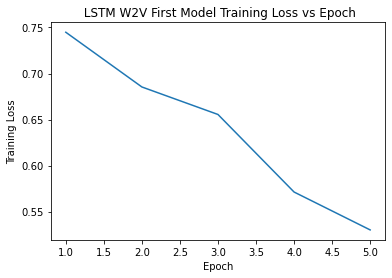

In [20]:
# Plotting Training Loss over epochs
plt.plot(np.arange(1,n_epochs+1),losses_train_list)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title(" LSTM W2V First Model Training Loss vs Epoch")
plt.show()

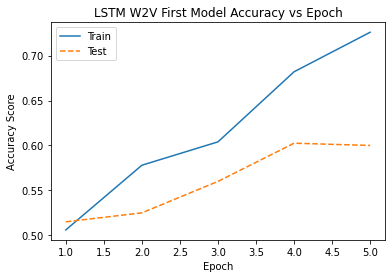

In [21]:
# Plotting training and test AUC score over epochs
plt.plot(np.arange(1,n_epochs+1),accuracy_train_list,label="Train")
plt.plot(np.arange(1,n_epochs+1),accuracy_test_list,'--',label="Test")
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.title("LSTM W2V First Model Accuracy vs Epoch")
plt.show()

# LSTM Glove Train

In [22]:
# Initiate the model with glove
model_lstmgl=lstmnet(150,150)

# Specify loss function - Binary Cross Entropy
criterion = nn.BCELoss()
# Specify optimizer - Adam
optimizer = torch.optim.Adam(model_lstmgl.parameters(), lr=0.01)
# optimizer2 = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer3 = torch.optim.Adam(model.parameters(), lr=0.002)


# Batch size will be 1 review at a time
batch_size=1
batch_size_test=1

# Loading the train and test set to a generator to save space
train_loader = torch.utils.data.DataLoader(train_set_united_glove, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set_united_glove, batch_size=batch_size_test)

# Number of epochs to train the model
n_epochs = 5

# Lists to store metrics
losses_list_lstmgl = []
accuracy_train_list_lstmgl=[]

accuracy_test_list_lstmgl=[]

for epoch in tqdm(range(1, n_epochs+1)):
    # Monitor training loss
    train_loss = 0.0
    accuracy=0.0
    accuracy_test=0.0

    ###################
    # Train the model #
    ###################
    model_lstmgl.train()
    for review,rating in train_loader:
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Create embedding
#         embedding=torch.unsqueeze(review,0)
        embedding=review
        # Forward pass: compute predicted outputs by passing inputs to the model, assuring the values are of type float
        outputs = model_lstmgl(embedding)
#         print(outputs)
        # Calculate the loss
        loss = criterion(outputs, rating.float())
        # Backward pass: compute gradient of the loss with respect to model parameters
#         loss.register_hook(lambda grad: print(grad))
        loss.backward()
        # Perform a single optimization step (parameter update)
#         if update_each == 100:
        optimizer.step()
#             update_each = 0
        # Update running training loss
        train_loss += loss.item()
        # Update running training accuracy
        outputs_acc=outputs.detach().numpy()
        accuracy+=accuracy_score(rating, np.round(outputs_acc))
    
    # Add train loss and accuracy to lists
    losses_list_lstmgl.append(train_loss/len(train_loader))
    accuracy_train_list_lstmgl.append(accuracy/len(train_loader))
    
    # Canceling the gradient optimizer while running on the validation data set (to save memory)
    with torch.no_grad():
        for review,rating in test_loader:
                # Create embedding
                embedding=review
                # Forward pass: compute predicted outputs by passing inputs to the model, assuring the values are of type float
                outputs = model_lstmgl(embedding)
                outputs_acc_test=outputs.detach().numpy()
                accuracy_test+=accuracy_score(rating, np.round(outputs_acc_test))

    accuracy_test_list_lstmgl.append(accuracy_test/len(test_loader))
    

    train_loss = train_loss/len(test_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    
    print('Epoch: {} \tTraining Accuracy: {:.6f}'.format(
        epoch, 
        accuracy/len(train_loader)
        ))
    
    print('Epoch: {} \tValidation Accuracy: {:.6f}'.format(
        epoch, 
        accuracy_test/len(test_loader)
        ))

 20%|████████████████▌                                                                  | 1/5 [02:00<08:01, 120.43s/it]

Epoch: 1 	Training Loss: 0.921526
Epoch: 1 	Training Accuracy: 0.484000
Epoch: 1 	Validation Accuracy: 0.517500


 40%|█████████████████████████████████▏                                                 | 2/5 [03:59<05:59, 119.77s/it]

Epoch: 2 	Training Loss: 0.889681
Epoch: 2 	Training Accuracy: 0.478000
Epoch: 2 	Validation Accuracy: 0.535000


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [05:58<03:58, 119.18s/it]

Epoch: 3 	Training Loss: 0.885328
Epoch: 3 	Training Accuracy: 0.506000
Epoch: 3 	Validation Accuracy: 0.522500


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [07:56<01:59, 119.02s/it]

Epoch: 4 	Training Loss: 0.888212
Epoch: 4 	Training Accuracy: 0.498000
Epoch: 4 	Validation Accuracy: 0.525000


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:58<00:00, 119.80s/it]

Epoch: 5 	Training Loss: 0.889278
Epoch: 5 	Training Accuracy: 0.536000
Epoch: 5 	Validation Accuracy: 0.525000


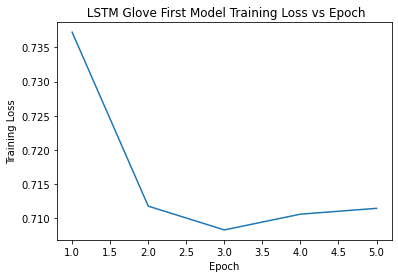

In [23]:
# Plotting Training Loss over epochs
plt.plot(np.arange(1,n_epochs+1),losses_list_lstmgl)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title(" LSTM Glove First Model Training Loss vs Epoch")
plt.show()

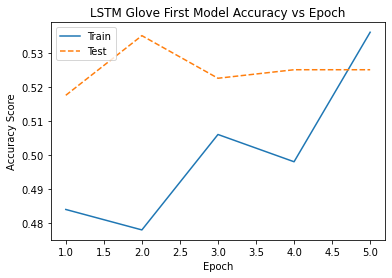

In [33]:
# Plotting training and test AUC score over epochs
plt.plot(np.arange(1,n_epochs+1),accuracy_train_list_lstmgl,label="Train")
plt.plot(np.arange(1,n_epochs+1),accuracy_test_list_lstmgl,'--',label="Test")
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.title("LSTM Glove First Model Accuracy vs Epoch")
plt.show()

# Expended Methods Comparision

### LSTM W2V Expended Model

In [25]:
# Initiate the model with expended w2v
modelw2vexp=lstmnet(200,200)

# Specify loss function - Binary Cross Entropy
criterion = nn.BCELoss()
# Specify optimizer - Adam
optimizer = torch.optim.Adam(modelw2vexp.parameters(), lr=0.01)
# optimizer2 = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer3 = torch.optim.Adam(model.parameters(), lr=0.002)



# Batch size will be 1 review at a time
batch_size=1
batch_size_test=1

# Loading the train and test set to a generator to save space
train_loader = torch.utils.data.DataLoader(train_set_united_expended2, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set_united_expeneded2, batch_size=batch_size_test)

# Number of epochs to train the model
n_epochs = 5

# Lists to store metrics
losses_train_list_expendedw2v = []
accuracy_train_list_expendedw2v = []

accuracy_test_list_expendedw2v = []

for epoch in tqdm(range(1, n_epochs+1)):
    # Monitor training loss
    train_loss = 0.0
    accuracy=0.0
    accuracy_test=0.0

    ###################
    # Train the model #
    ###################
    model.train()
    for review,rating in train_loader:
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Create embedding
        embedding=review
        # Forward pass: compute predicted outputs by passing inputs to the model, assuring the values are of type float
        outputs = modelw2vexp(embedding)
        # Calculate the loss
        loss = criterion(outputs, rating.float())
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update running training loss
        train_loss += loss.item()
        # Update running training accuracy
        outputs_acc=outputs.detach().numpy()
        accuracy+=accuracy_score(rating, np.round(outputs_acc))
    
    # Add train loss and accuracy to lists
    losses_train_list_expendedw2v.append(train_loss/len(train_loader))
    accuracy_train_list_expendedw2v.append(accuracy/len(train_loader))
    

    


    # Canceling the gradient optimizer while running on the validation data set (to save memory)
    with torch.no_grad():
        for review,rating in test_loader:
                # Create embedding
                embedding=review
                # Forward pass: compute predicted outputs by passing inputs to the model, assuring the values are of type float
                outputs = modelw2vexp(embedding)
                outputs_acc_test=outputs.detach().numpy()
                accuracy_test+=accuracy_score(rating, np.round(outputs_acc_test))


#     accuracy_test_list.append(accuracy/len(train_loader))
    accuracy_test_list_expendedw2v.append(accuracy_test/len(test_loader))
    

    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    
    print('Epoch: {} \tTraining Accuracy: {:.6f}'.format(
        epoch, 
        accuracy/len(train_loader)
        ))
    
    print('Epoch: {} \tValidation Accuracy: {:.6f}'.format(
        epoch, 
        accuracy_test/len(test_loader)
        ))
    

 20%|████████████████▌                                                                  | 1/5 [02:05<08:22, 125.66s/it]

Epoch: 1 	Training Loss: 0.779075
Epoch: 1 	Training Accuracy: 0.518000
Epoch: 1 	Validation Accuracy: 0.520000


 40%|█████████████████████████████████▏                                                 | 2/5 [04:13<06:20, 126.96s/it]

Epoch: 2 	Training Loss: 0.687875
Epoch: 2 	Training Accuracy: 0.636000
Epoch: 2 	Validation Accuracy: 0.582500


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [06:33<04:25, 132.85s/it]

Epoch: 3 	Training Loss: 0.540367
Epoch: 3 	Training Accuracy: 0.712000
Epoch: 3 	Validation Accuracy: 0.575000


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [08:47<02:13, 133.21s/it]

Epoch: 4 	Training Loss: 0.398821
Epoch: 4 	Training Accuracy: 0.810000
Epoch: 4 	Validation Accuracy: 0.587500


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:54<00:00, 130.91s/it]

Epoch: 5 	Training Loss: 0.273367
Epoch: 5 	Training Accuracy: 0.906000
Epoch: 5 	Validation Accuracy: 0.557500


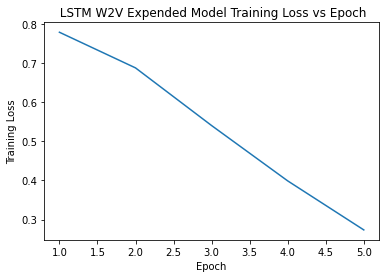

In [26]:
# Plotting Training Loss over epochs
plt.plot(np.arange(1,n_epochs+1),losses_train_list_expendedw2v)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title(" LSTM W2V Expended Model Training Loss vs Epoch")
plt.show()

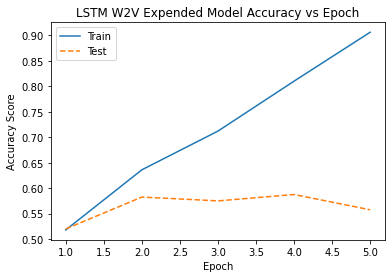

In [34]:
# Plotting training and test AUC score over epochs
plt.plot(np.arange(1,n_epochs+1),accuracy_train_list_expendedw2v,label="Train")
plt.plot(np.arange(1,n_epochs+1),accuracy_test_list_expendedw2v,'--',label="Test")
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.title("LSTM W2V Expended Model Accuracy vs Epoch")
plt.show()

### LSTM Glove Expended Model

In [28]:
# Initiate the model with glove expended
model_lstmgl_exp=lstmnet(200,200)

# Specify loss function - Binary Cross Entropy
criterion = nn.BCELoss()
# Specify optimizer - Adam
optimizer = torch.optim.Adam(model_lstmgl_exp.parameters(), lr=0.01)
# optimizer2 = torch.optim.Adam(model.parameters(), lr=0.0001)
# optimizer3 = torch.optim.Adam(model.parameters(), lr=0.002)


# Batch size will be 1 review at a time
batch_size=1
batch_size_test=1

# Loading the train and test set to a generator to save space
train_loader = torch.utils.data.DataLoader(train_set_united_glove_expended2, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set_united_glove_expeneded2, batch_size=batch_size_test)

# Number of epochs to train the model
n_epochs = 5

# Lists to store metrics
losses_list_lstmgl_expended = []
accuracy_train_list_lstmgl_expended=[]

accuracy_test_list_lstmgl_expended=[]

for epoch in tqdm(range(1, n_epochs+1)):
    # Monitor training loss
    train_loss = 0.0
    accuracy=0.0
    accuracy_test=0.0

    ###################
    # Train the model #
    ###################
    model_lstmgl.train()
    for review,rating in train_loader:
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Create embedding
#         embedding=torch.unsqueeze(review,0)
        embedding=review
        # Forward pass: compute predicted outputs by passing inputs to the model, assuring the values are of type float
        outputs = model_lstmgl_exp(embedding)
#         print(outputs)
        # Calculate the loss
        loss = criterion(outputs, rating.float())
        # Backward pass: compute gradient of the loss with respect to model parameters
#         loss.register_hook(lambda grad: print(grad))
        loss.backward()
        # Perform a single optimization step (parameter update)
#         if update_each == 100:
        optimizer.step()
#             update_each = 0
        # Update running training loss
        train_loss += loss.item()
        # Update running training accuracy
        outputs_acc=outputs.detach().numpy()
        accuracy+=accuracy_score(rating, np.round(outputs_acc))
    
    # Add train loss and accuracy to lists
    losses_list_lstmgl_expended.append(train_loss/len(train_loader))
    accuracy_train_list_lstmgl_expended.append(accuracy/len(train_loader))
    
    # Canceling the gradient optimizer while running on the validation data set (to save memory)
    with torch.no_grad():
        for review,rating in test_loader:
                # Create embedding
                embedding=review
                # Forward pass: compute predicted outputs by passing inputs to the model, assuring the values are of type float
                outputs = model_lstmgl_exp(embedding)
                outputs_acc_test=outputs.detach().numpy()
                accuracy_test+=accuracy_score(rating, np.round(outputs_acc_test))

    accuracy_test_list_lstmgl_expended.append(accuracy_test/len(test_loader))
    

    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
    
    print('Epoch: {} \tTraining Accuracy: {:.6f}'.format(
        epoch, 
        accuracy/len(train_loader)
        ))
    
    print('Epoch: {} \tValidation Accuracy: {:.6f}'.format(
        epoch, 
        accuracy_test/len(test_loader)
        ))

 20%|████████████████▌                                                                  | 1/5 [02:07<08:29, 127.37s/it]

Epoch: 1 	Training Loss: 0.749827
Epoch: 1 	Training Accuracy: 0.516000
Epoch: 1 	Validation Accuracy: 0.502500


 40%|█████████████████████████████████▏                                                 | 2/5 [04:16<06:24, 128.24s/it]

Epoch: 2 	Training Loss: 0.763410
Epoch: 2 	Training Accuracy: 0.506000
Epoch: 2 	Validation Accuracy: 0.515000


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [06:22<04:14, 127.22s/it]

Epoch: 3 	Training Loss: 0.723594
Epoch: 3 	Training Accuracy: 0.512000
Epoch: 3 	Validation Accuracy: 0.505000


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [08:34<02:09, 129.21s/it]

Epoch: 4 	Training Loss: 0.699069
Epoch: 4 	Training Accuracy: 0.542000
Epoch: 4 	Validation Accuracy: 0.550000


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:42<00:00, 128.45s/it]

Epoch: 5 	Training Loss: 0.713869
Epoch: 5 	Training Accuracy: 0.538000
Epoch: 5 	Validation Accuracy: 0.500000


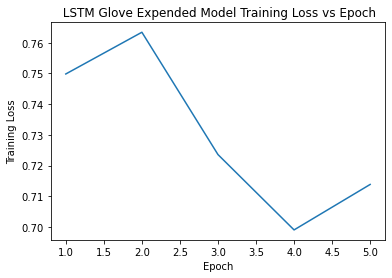

In [29]:
# Plotting Training Loss over epochs
plt.plot(np.arange(1,n_epochs+1),losses_list_lstmgl_expended)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title(" LSTM Glove Expended Model Training Loss vs Epoch")
plt.show()

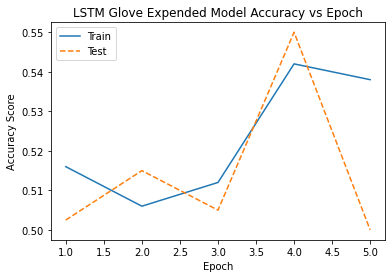

In [30]:
# Plotting training and test AUC score over epochs
plt.plot(np.arange(1,n_epochs+1),accuracy_train_list_lstmgl_expended,label="Train")
plt.plot(np.arange(1,n_epochs+1),accuracy_test_list_lstmgl_expended,'--',label="Test")
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.title("LSTM Glove Expended Model Accuracy vs Epoch")
plt.show()

# All Models Comparision

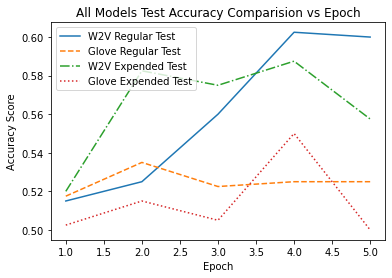

In [43]:
plt.plot(np.arange(1,n_epochs+1),accuracy_test_list,label="W2V Regular Test")
plt.plot(np.arange(1,n_epochs+1),accuracy_test_list_lstmgl,'--',label="Glove Regular Test")
plt.plot(np.arange(1,n_epochs+1),accuracy_test_list_expendedw2v,'-.',label="W2V Expended Test")
plt.plot(np.arange(1,n_epochs+1),accuracy_test_list_lstmgl_expended,':',label="Glove Expended Test")
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.title("All Models Test Accuracy Comparision vs Epoch")
plt.show()

#### We can see that the Regular W2V LSTM Model performed the best. The glove models had lower performence than the W2V models. Overall we have received a decent accuracy score (although not high as expected for an easy task like this), probably because we had to use smaller data batches (so we won't exceed memory and time limits) and train the model for a low amount of epochs (5). Higher train data and number of epochs, and usage of a more broad random search (especially changing the window size and vector size of the embedding model, and learning rate of the optimizer) may result in better performence. Moreover, using AUC as another metric can result in a better understanding of the adequate threshold for the classification.